In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from PIL import Image

from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

train_on_gpu = True

2024-04-12 23:58:00.658492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 23:58:00.658596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 23:58:00.799331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read data

DATA_PATH = '/kaggle/input/histopathologic-cancer-detection'

tain_df = pd.read_csv(os.path.join(DATA_PATH, 'train_labels.csv'))
samle_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

tain_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
tain_df = tain_df.head(10000) # reducing number of enteries to 2% make it to run faster
tain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [4]:
# Check distinct labels

distinct_labels = tain_df['label'].unique()

distinct_labels # array([0, 1]) - 0

array([0, 1])

In [5]:
# Lets select sample of each label category & check the shape
# 1 - c18f2d887b7ae4f6742ee445113fa1aef383ed77
# 0 - 068aba587a4950175d04c680d38943fd488d6a9d

positive_sample = Image.open(os.path.join(DATA_PATH, "train", "c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif"))
print(f"Cancerous image shape -> {np.array(positive_sample).shape}")

negative_sample = Image.open(os.path.join(DATA_PATH, "train", "755db6279dae599ebb4d39a9123cce439965282d.tif"))
print(f"Non-Cancerous image shape -> {np.array(negative_sample).shape}")


IMAGE_SIZE = 96 # image size is 96

Cancerous image shape -> (96, 96, 3)
Non-Cancerous image shape -> (96, 96, 3)


In [6]:
def display_sample_images(random_samples):
    img = plt.figure(figsize=(25, 4))
    i = 0
    for train_image in random_samples:
        ax = img.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        im = Image.open(os.path.join(DATA_PATH, "train", f"{train_image}.tif"))
        plt.imshow(im)
        
        i += 1

Cancerous Images - Samples


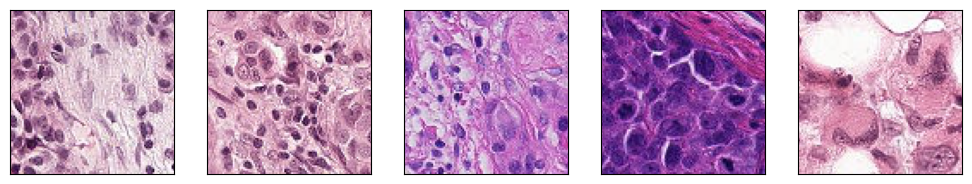

In [7]:
print("Cancerous Images - Samples")
display_sample_images(tain_df[tain_df['label'] == 1]['id'].sample(n=5, replace=False).tolist())

Non-Cancerous Images - Samples


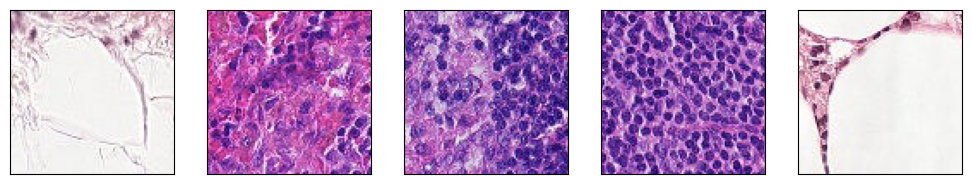

In [8]:
print("Non-Cancerous Images - Samples")
display_sample_images(tain_df[tain_df['label'] == 0]['id'].sample(n=5, replace=False).tolist())

### Exploratory Data Analysis (EDA) — Inspect, Visualize & Clean

In [9]:
# Exploring the distribution of labels in the training dataset.
tain_df['label_name'] = tain_df['label'].map({0: 'Non-Cancerous', 1: 'Cancerous'}) # Giving name to label
tain_df['image'] = os.path.join(DATA_PATH, "train") + '/' + tain_df['id'] + '.tif' # new column with image absolute path

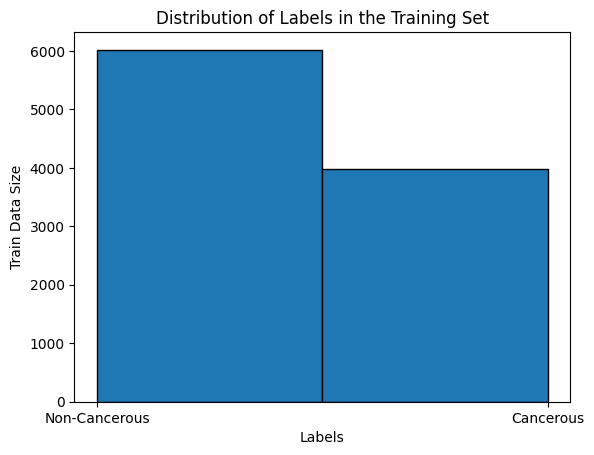

In [10]:
plt.hist(tain_df['label'], bins=2, edgecolor='black')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.xlabel('Labels')
plt.ylabel('Train Data Size')
plt.title('Distribution of Labels in the Training Set')
plt.show()

Lets load the image data itself and perform a train-validation split

The data generator utilizes batch loading, loading images into memory as required for each batch and replacing them when the subsequent batch is processed. This approach alleviates memory strain during training. Additionally, the ImageDataGenerator() object rescales the RGB pixels within each image to range between 0 and 1, while also executing a 70 : 30 validation split.


In [11]:
datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [12]:
train_generator = datagenerator.flow_from_dataframe(
    dataframe=tain_df,
    x_col="image",
    y_col="label_name",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

Found 7000 non-validated image filenames belonging to 2 classes.


In [13]:
validation_generator = datagenerator.flow_from_dataframe(
    dataframe=tain_df,
    x_col="image",
    y_col="label_name",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

Found 3000 non-validated image filenames belonging to 2 classes.


In [14]:
# Generate - Test data Set
TEST_DATA_DIR = os.path.join(DATA_PATH, "test")

test_df = pd.DataFrame({'image': os.listdir(TEST_DATA_DIR)})
test_df['image'] = os.path.join(TEST_DATA_DIR) + '/' + test_df['image']


test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


## Modeling

#### Basic CNN

Classify the data using a sequential, dense neural network, as covered in earlier modules. The network architecture includes a flattening layer to convert the input into an array, followed by dense, fully connected layers of sizes 128, 64, 32, and 16, each employing a 'relu' activation function. Finally, the network concludes with an output layer featuring a 'sigmoid' activation function.

In [15]:
basic_cnn_model = models.Sequential()

basic_cnn_model.add(layers.Flatten(input_shape=(96, 96, 3)))

basic_cnn_model.add(layers.Dense(128, activation='relu'))
basic_cnn_model.add(layers.Dense(64, activation='relu'))
basic_cnn_model.add(layers.Dense(32, activation='relu'))
basic_cnn_model.add(layers.Dense(16, activation='relu'))

basic_cnn_model.add(layers.Dense(1, activation='sigmoid'))

basic_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,539,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,549,953 (13.54 MB)

 Trainable params: 3,549,953 (13.54 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
basic_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

basic_cnn_history = basic_cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
  3/219 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.2812 - auc: 0.5833 - loss: 1.2583

I0000 00:00:1712966300.289945      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 242ms/step - accuracy: 0.5458 - auc: 0.5464 - loss: 0.8794 - val_accuracy: 0.6027 - val_auc: 0.6311 - val_loss: 0.6862
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.5924 - auc: 0.6156 - loss: 0.6722 - val_accuracy: 0.5940 - val_auc: 0.6684 - val_loss: 0.6438
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.6039 - auc: 0.6320 - loss: 0.6783 - val_accuracy: 0.6060 - val_auc: 0.6675 - val_loss: 0.6384
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.6160 - auc: 0.6454 - loss: 0.6431 - val_accuracy: 0.6177 - val_auc: 0.6557 - val_loss: 0.6327
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6369 - auc: 0.6793 - loss: 0.6204 - val_accuracy: 0.6227 - val_auc: 0.6636 - val_loss: 0.6297
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.6467 - auc: 0.6780 - loss: 0.6223 - val_accuracy: 0.6010 - val_auc: 0.6840 - val_loss: 0.6349
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━

In [17]:
def performance_plot(history, model):
    """
    Helper method to performance plots
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Accuracy
    ax1.plot(history.history['accuracy'], label = 'Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(np.arange(0, 5, 1))
    ax1.set_title('Accuracy by Epoch')
    ax1.legend(loc='lower right')

    # Loss
    ax2.plot(history.history['loss'], label = 'Training Loss')
    ax2.plot(history.history['val_loss'], label = 'Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_xticks(np.arange(0, 5, 1))
    ax2.set_title('Loss by Epoch')
    ax2.legend(loc='lower right')

    # AUC
    ax3.plot(history.history['auc'], label = 'Training AUC')
    ax3.plot(history.history['val_auc'], label = 'Validation AUC')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.set_xticks(np.arange(0, 5, 1))
    ax3.set_title('AUC by Epoch')
    ax3.legend(loc='lower right')

    fig.suptitle(f'{model} - Measuring Dense, Sequential Net Performance')
    plt.show()

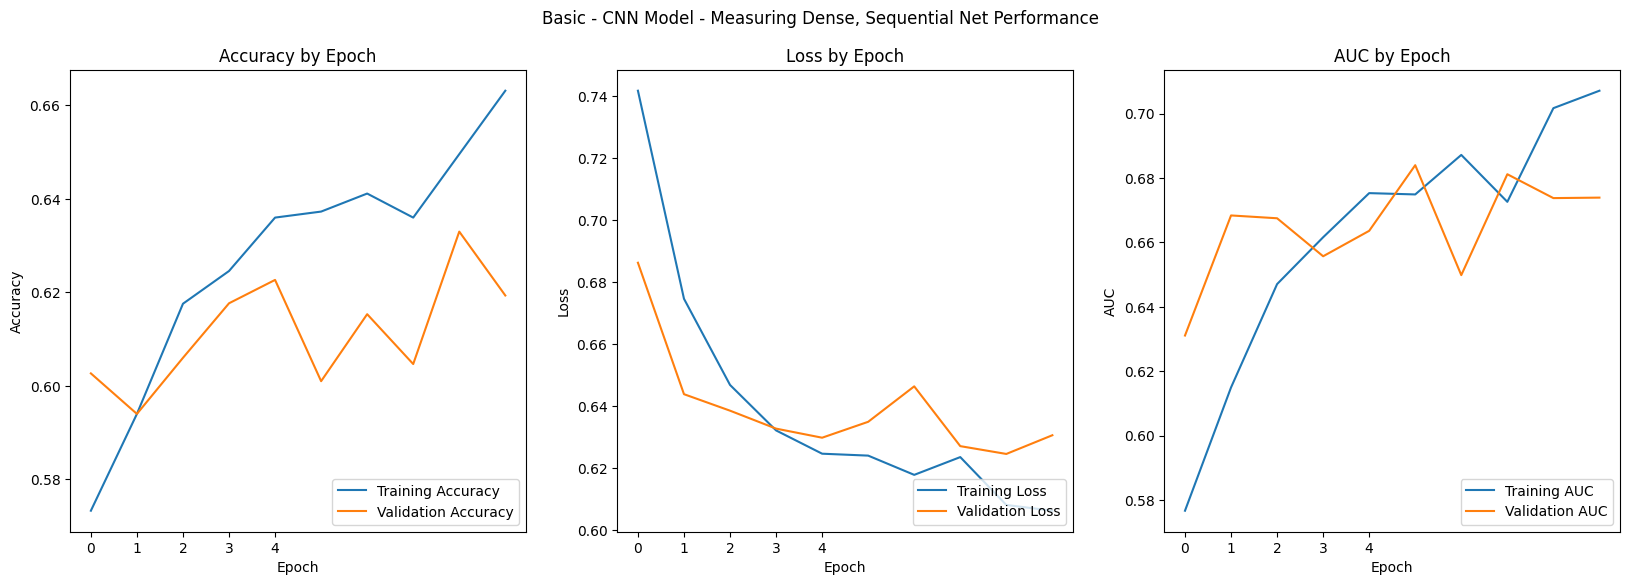

In [18]:
# Plotting
performance_plot(basic_cnn_history, 'Basic - CNN Model')

In [19]:
# Predication
prediction_labels = basic_cnn_model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 317s 177ms/step


In [20]:
basic_cnn_model_pred_df = pd.DataFrame(columns=['id', 'label'])

basic_cnn_model_pred_df['id'] = [filename.split('.')[0] for filename in os.listdir(TEST_DATA_DIR)]
basic_cnn_model_pred_df['label'] = np.round(prediction_labels.flatten()).astype('int')

basic_cnn_model_pred_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,1
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


Although it seemed that the model might have started to overfit after the completion of the third epoch, indicated by the decrease in validation accuracy and increase in loss, the results from the fourth and fifth epochs suggested that there was still potential for improvement in the neural network's predictive ability.

Unfortunately, due to constraints on memory and time used only 5 epochs. The training metrics seem to be reaching a point of diminishing returns, making it intriguing to see how the validation metrics would have responded.

While this model performs adequately, its architecture is limited to processing raw pixels and lacks the ability to interpret the proximity of pixels or larger structures. Thus, I am confident that when we test a CNN next, it will surpass the performance of this model.

#### CNN Model - Average pooling

Average pooling is commonly employed in CNN architectures, usually after convolutional layers, to progressively decrease the spatial dimensions (width, height) of the feature maps while increasing the depth. This facilitates capturing more abstract features in the later layers of the network.

In [21]:
avg_pooling_cnn_model = models.Sequential()

avg_pooling_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))

avg_pooling_cnn_model.add(layers.AveragePooling2D((2, 2)))
avg_pooling_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))

avg_pooling_cnn_model.add(layers.AveragePooling2D((2, 2)))
avg_pooling_cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))

avg_pooling_cnn_model.add(layers.Flatten())

avg_pooling_cnn_model.add(layers.Dense(128, activation='relu'))
avg_pooling_cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
avg_pooling_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

avg_pooling_cnn_history = avg_pooling_cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


2024-04-13 00:06:47.081997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.17839, expected 5.44963
2024-04-13 00:06:47.082052: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8839: 5.09095, expected 4.36218
2024-04-13 00:06:47.082062: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8843: 6.28436, expected 5.55559
2024-04-13 00:06:47.082070: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8845: 5.83888, expected 5.11011
2024-04-13 00:06:47.082077: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8846: 5.57204, expected 4.84327
2024-04-13 00:06:47.082084: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8848: 6.03331, expected 5.30455
2024-04-13 00:06:47.082092: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8849: 5.66228, expected 4.93352
2024-04-13 00:06:47.082099: E exte

150/219 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6169 - auc: 0.6107 - loss: 0.6813

2024-04-13 00:06:57.142941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 61: 5.37684, expected 4.72812
2024-04-13 00:06:57.143004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 5.04438, expected 4.39567
2024-04-13 00:06:57.143013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 5.09564, expected 4.44692
2024-04-13 00:06:57.143021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84: 5.2799, expected 4.63119
2024-04-13 00:06:57.143028: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98: 5.14145, expected 4.49274
2024-04-13 00:06:57.143038: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100: 5.19586, expected 4.54714
2024-04-13 00:06:57.143046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128: 5.46686, expected 4.81814
2024-04-13 00:06:57.143053: E external/local_xl

219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.6357 - auc: 0.6417 - loss: 0.6586 - val_accuracy: 0.7240 - val_auc: 0.8154 - val_loss: 0.5601
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.7459 - auc: 0.7983 - loss: 0.5370 - val_accuracy: 0.7490 - val_auc: 0.8195 - val_loss: 0.5240
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7593 - auc: 0.8236 - loss: 0.5054 - val_accuracy: 0.7677 - val_auc: 0.8234 - val_loss: 0.5116
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7696 - auc: 0.8297 - loss: 0.4983 - val_accuracy: 0.7483 - val_auc: 0.8278 - val_loss: 0.5328
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.7685 - auc: 0.8264 - loss: 0.5006 - val_accuracy: 0.7693 - val_auc: 0.8323 - val_loss: 0.4959
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.7695 - auc: 0.8348 - loss: 0.4897 - val_accuracy: 0.7623 - val_auc: 0.8235 - val_loss: 0.5073
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━

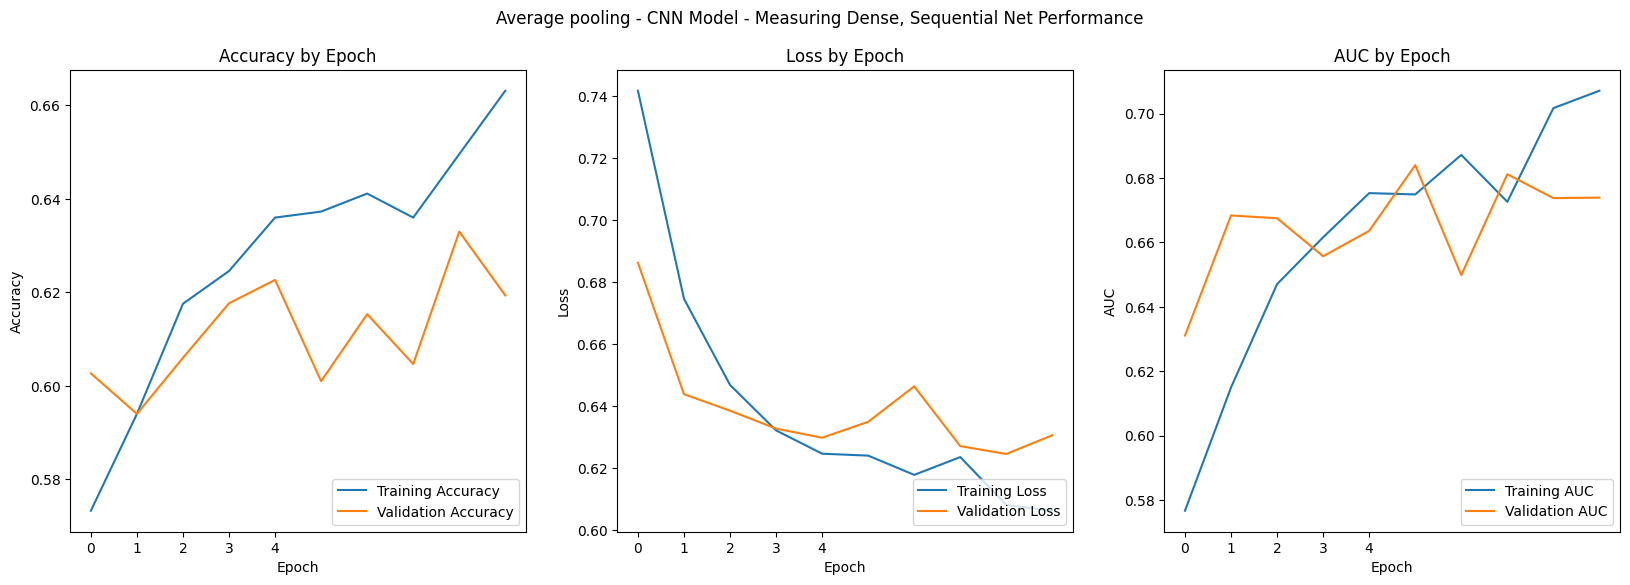

In [23]:
# Plotting

performance_plot(basic_cnn_history, 'Average pooling - CNN Model')

In [24]:
# Predication

prediction_labels = avg_pooling_cnn_model.predict(test_generator)

avg_pooling_cnn_model_pred_df = pd.DataFrame(columns=['id', 'label'])

avg_pooling_cnn_model_pred_df['id'] = [filename.split('.')[0] for filename in os.listdir(TEST_DATA_DIR)]
avg_pooling_cnn_model_pred_df['label'] = np.round(prediction_labels.flatten()).astype('int')

avg_pooling_cnn_model_pred_df.head()

1795/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

2024-04-13 00:10:49.578721: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1169: 5.18307, expected 4.53467
2024-04-13 00:10:49.578789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1539: 5.09214, expected 4.44374
2024-04-13 00:10:49.578800: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2187: 5.47877, expected 4.83037
2024-04-13 00:10:49.578832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4250: 5.16469, expected 4.51629
2024-04-13 00:10:49.578847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5885: 5.34781, expected 4.69941
2024-04-13 00:10:49.578866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8836: 6.81719, expected 5.85922
2024-04-13 00:10:49.578874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8837: 7.96806, expected 7.01009
2024-04-13 00:10:49.578882: E exte

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 89s 49ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,1
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


Implementing the CNN with average pooling performs well, Across the training period the average pooling CNN tends to be a slighly worse version of the max pooling CNN.

### Save predicutions

In [25]:
avg_pooling_cnn_model_pred_df.to_csv('basic_cnn.csv', index=False)

AttributeError: 'History' object has no attribute 'to_csv'